In [1]:
# === Imports ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

# === Step 1: Load and Transform Dataset ===
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

def transform_dataset(df):
    rows = []
    for _, row in df.iterrows():
        for i in range(row['vsv_noemer']):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < row['vsv_teller'] else 0
            rows.append(new_row)
    return pd.DataFrame(rows).drop(columns=['vsv_noemer'])

df = transform_dataset(bad_df)
df.drop(columns=['schooljaar'], inplace=True)

# === Step 2: Prepare X and y ===
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

In [2]:
# === Step 3: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
# === Step 4: Preprocessing Pipeline ===
categorical_cols = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
], remainder='passthrough')

In [4]:
# === Step 5: Model Training ===
model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [5]:
# Define the subgroup (hypothesis): male, non-Belgian, big city
big_cities = ['Antwerpen']  # adjust as needed

subgroup_mask = (
    (X_test['geslacht'] == 'Mannelijk') &
    (X_test['belg_nietbelg'] == 'niet-Belg') &
    (X_test['woonplaats_fusiegemeente_naam'].isin(big_cities))
)

# Global confusion matrix
global_cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = global_cm.ravel()
global_fpr = fp / (fp + tn)
global_fnr = fn / (fn + tp)

# Subgroup confusion matrix
subgroup_y_true = y_test[subgroup_mask]
subgroup_y_pred = y_pred[subgroup_mask]
subgroup_cm = confusion_matrix(subgroup_y_true, subgroup_y_pred)
sub_tn, sub_fp, sub_fn, sub_tp = subgroup_cm.ravel()
subgroup_fpr = sub_fp / (sub_fp + sub_tn)
subgroup_fnr = sub_fn / (sub_fn + sub_tp)

# Print for debugging
print(f"Global FNR: {global_fnr:.3f}, FPR: {global_fpr:.3f}")
print(f"Subgroup FNR: {subgroup_fnr:.3f}, FPR: {subgroup_fpr:.3f}")

Global FNR: 0.299, FPR: 0.012
Subgroup FNR: 0.233, FPR: 0.075


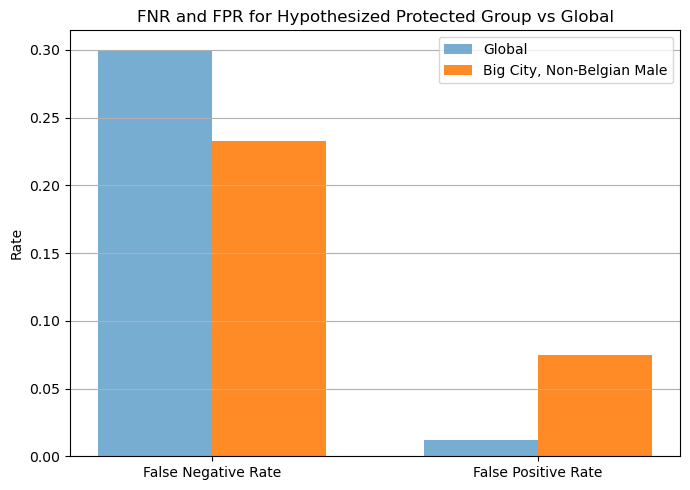

In [6]:
# Plot
labels = ['False Negative Rate', 'False Positive Rate']
global_values = [global_fnr, global_fpr]
subgroup_values = [subgroup_fnr, subgroup_fpr]

x = range(len(labels))
plt.figure(figsize=(7, 5))
plt.bar(x, global_values, width=0.35, label='Global', alpha=0.6)
plt.bar([i + 0.35 for i in x], subgroup_values, width=0.35, label='Big City, Non-Belgian Male', alpha=0.9)
plt.xticks([i + 0.175 for i in x], labels)
plt.ylabel('Rate')
plt.title('FNR and FPR for Hypothesized Protected Group vs Global')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

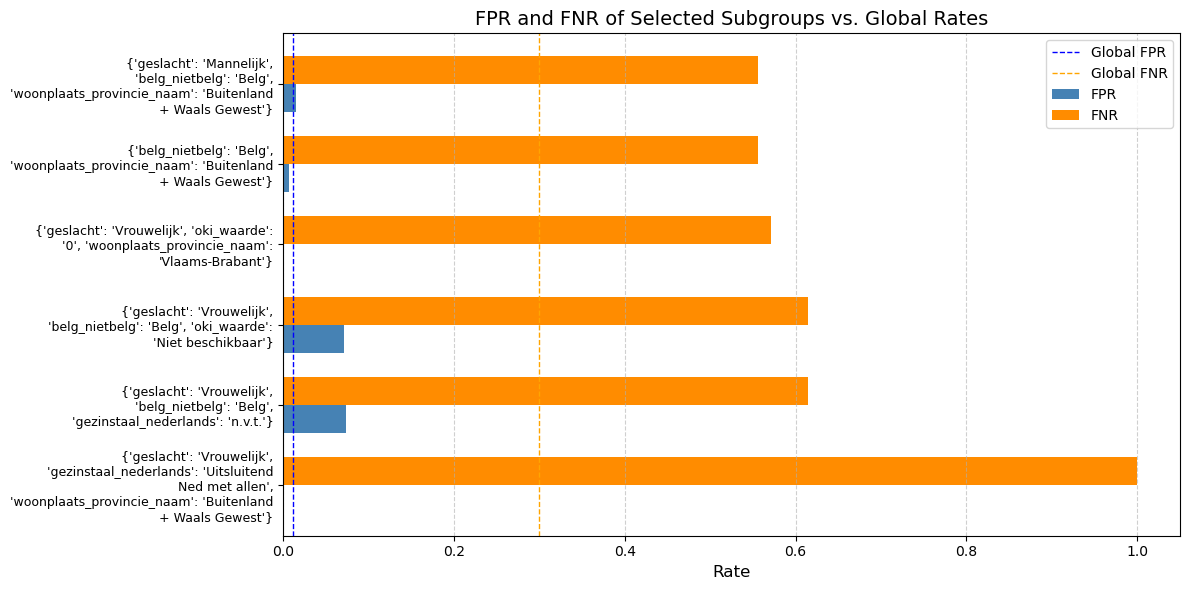

In [14]:
import textwrap

# === Step 8: Visualize Top Deviating Groups ===
df_results = pd.DataFrame(results)
top_results = df_results.sort_values(by='fnr_diff', ascending=False).head(6)

# Wrap long group labels
def wrap_label(label, width=40):
    return '\n'.join(textwrap.wrap(label, width))

wrapped_labels = [wrap_label(label) for label in top_results['group']]

plt.figure(figsize=(12, 6))
bar_width = 0.35
y = range(len(top_results))

plt.barh(y, top_results['fpr'], height=bar_width, label='FPR', color='steelblue')
plt.barh([i + bar_width for i in y], top_results['fnr'], height=bar_width, label='FNR', color='darkorange')

plt.axvline(x=fpr_global, color='blue', linestyle='--', linewidth=1, label='Global FPR')
plt.axvline(x=fnr_global, color='orange', linestyle='--', linewidth=1, label='Global FNR')

plt.yticks([i + bar_width / 2 for i in y], wrapped_labels, fontsize=9)
plt.xlabel("Rate", fontsize=12)
plt.title("FPR and FNR of Selected Subgroups vs. Global Rates", fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
